MATRIZ MN: 
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
   48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
   78  79  80  81  82  83  84  85  86  87  88  89]
 [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
  138 139 140 141 142 143 144 145 146 147 148 149]
 [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
  168 169 170 171 172 173 174 175 176 177 178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209]
 [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
  228 229 230 231 232 233 234 235 236 2

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

O ficheiro para leitura em paraview foi escrito em results_paraview.vtk.


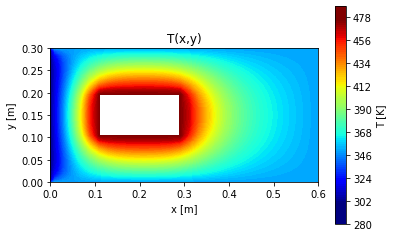

In [1]:
# Código geral para obtenção da distribuição de temperaturas para problemas de condução para geometrias simples
# André Henriques Nº 57561

#! INSTRUÇÕES DE USO
#!    1) Este é um código geral mas deve ser usado conjuntamente com a folha de cálculo 'Malha.xlsx' 
#!    2) Todas as instruções da construção da malha devem ser cumpridas. Referir a 'Malha.xlsx' para mais informações
#!    3) Antes de simular deve-se selecionar a folha da folha de cálculo a usar (apenas algumas linhas abaixo)
#!    4) Na secção do plot dos resultados deve-se selecionar a respetiva linha, as restantes devem ser comentadas. É posível adicionar mais 
#!        para outras malhas alterando as temperaturas mínimas e máximas
#!    5) São dadas informações adicionais sobre as matrizes e elementos no output


# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from scipy.interpolate import griddata
import pandas as pd
import meshio
import csv

# Malha
Ficheiro_malha = 'Malha.xlsx'                    #! Escolher o ficheiro excel na mesma diretoria deste documento .ipynb
Malha_folha = 'Malha_0'                                #! Escolher a folha com a malha pretendida
df = pd.read_excel(Ficheiro_malha, Malha_folha)

ativar_fronteira = 1                                   #! 1 - ativar, 0 - não ativar. Só usar na Malha_0 para obter a geometria completa

validação_caso_simples = 0                 #! 1 - ativar, 0 - não ativar. Comparação entre a solução analítica e a numérica para um caso simples
                                           #! Usar a Malha_1 neste caso

# Parâmetros físicos
k = 380  # Condutividade termica [W/(mK)]
q = 0 #[w/m^3]

# Funções integradas
def obter_T(TXY, i):
    TXY = TXY.replace(" ", "")
    TXY = TXY[2 : len(TXY)-1]
    TXY = TXY.split(',')
    TXY = TXY[i]
    return TXY


# Parâmetros geométricos
de = df.iloc[1, 4] # Espessura da placa [m]
dx = df.iloc[4, 4] # espacamento x
dy = df.iloc[4, 5] # espacamento y
Lx = df.iloc[4, 2]
Ly = df.iloc[4, 3]
Nx = df.iloc[1, 2]
Ny = df.iloc[1, 3]
NROWS = df.iloc[1, 3]
NCOL = [9]
for i in range(0, df.iloc[1, 2]-1):
    NCOL.append(NCOL[i]+1)
NCOL_total = list(NCOL)
NCOL_total.insert(0, NCOL[0]-1)
NCOL_total.insert(len(NCOL_total), NCOL[len(NCOL_total)-2]+1)

TOTAL = pd.read_excel(Ficheiro_malha, sheet_name=Malha_folha, skiprows = 2,  nrows = NROWS+2, usecols = NCOL_total)
TOTAL = np.array(TOTAL)
MN = pd.read_excel(Ficheiro_malha, sheet_name=Malha_folha, skiprows = 3,  nrows = NROWS, usecols = NCOL)
MN = np.array(MN)



PF = []
n_nan = 0
c_linha = -1
for linha in MN:
    c_linha += 1
    c_n = -1
    for n in linha:
        c_n += 1
        if str(n).isnumeric() == False:
            n_nan += 1
            PF.append((c_linha, c_n, str(n)))
            linha[c_n] = -1
MN_PARAVIEW = MN
MN_PARAVIEW = np.where(MN==-1, np.nan, MN_PARAVIEW)
MN = MN.astype(int)
print(f"MATRIZ MN: \n{MN}\n")

NCOL = [9+Nx+2]
for i in range(0, df.iloc[1, 2]-1):
    NCOL.append(NCOL[i]+1)
x = pd.read_excel(Ficheiro_malha, sheet_name=Malha_folha, skiprows = 3,  nrows = NROWS, usecols = NCOL)
x = np.array(x)

print(f"MATRIZ x: \n{x}\n")
NCOL = [9 + 2*Nx + 4]
for i in range(0, df.iloc[1, 2]-1):
    NCOL.append(NCOL[i]+1)
y = pd.read_excel(Ficheiro_malha, sheet_name=Malha_folha, skiprows = 3,  nrows = NROWS, usecols = NCOL)
y = np.array(y)
print(f"MATRIZ y: \n{y}\n")

 
# Classificar cada ponto conforme o número de pontos fronteira na sua vizinhança. Casos = N + S + O + E + NS + NO + NE + SO + SE + OE + NSO + NSE + NOE + SOE + Nenhum 

B_N, B_S, B_O, B_E, B_NS, B_NO, B_NE, B_SO, B_SE, B_OE, B_NSO, B_NSE, B_NOE, B_SOE, B_VAZIO, B_INT = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
LT_N, LT_S, LT_O, LT_E, LT_NS, LT_NO, LT_NE, LT_SO, LT_SE, LT_OE, LT_NSO, LT_NSE, LT_NOE, LT_SOE = [],[],[],[],[],[],[],[],[],[],[],[],[],[]

for linha in range(1, TOTAL.shape[0]):
    for n in range(1, TOTAL.shape[1]):
        if str(TOTAL[linha, n]).isnumeric() == True:

            if TOTAL[linha - 1, n] not in list(range(0, MN[-1,-1]+1)): # Possibilidade N, NS, NO, NE, NSO, NSE, NOE 

                if linha + 1 < TOTAL.shape[0] and n + 1 < TOTAL.shape[1]:
                    if TOTAL[linha + 1, n] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha, n-1]).isnumeric() == True and str(TOTAL[linha, n+1]).isnumeric() == True: # Possibilidades NS
                        B_NS.append(MN[linha - 1, n - 1])
                        LT_NS.append([TOTAL[linha + 1, n], TOTAL[linha - 1, n]])
                        print('NS')
                        print(TOTAL[linha + 1, n], TOTAL[linha - 1, n])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    elif TOTAL[linha, n - 1] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha + 1, n]).isnumeric() == True and str(TOTAL[linha, n + 1]).isnumeric() == True: #Possibilidade NO
                        B_NO.append(MN[linha - 1, n - 1])
                        LT_NO.append([TOTAL[linha - 1, n], TOTAL[linha, n - 1]])
                        print('NO')
                        print(TOTAL[linha - 1, n], TOTAL[linha, n - 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    elif TOTAL[linha, n + 1] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha + 1, n]).isnumeric() == True and str(TOTAL[linha, n - 1]).isnumeric() == True: #Possibilidade NE
                        B_NE.append(MN[linha - 1, n - 1])
                        LT_NE.append([TOTAL[linha - 1, n], TOTAL[linha, n + 1]])
                        print('NE')
                        print(TOTAL[linha - 1, n], TOTAL[linha, n + 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    elif TOTAL[linha, n - 1] not in list(range(0, MN[-1,-1]+1)) and TOTAL[linha + 1 , n] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha, n + 1]).isnumeric() == True: #Possibilidade NSO
                        B_NSO.append(MN[linha - 1, n - 1])
                        LT_NSO.append([TOTAL[linha - 1, n], TOTAL[linha + 1, n], TOTAL[linha, n - 1]])
                        print('NSO')
                        print(TOTAL[linha - 1, n], TOTAL[linha + 1, n], TOTAL[linha, n - 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')
                    
                    elif TOTAL[linha, n + 1] not in list(range(0, MN[-1,-1]+1)) and TOTAL[linha + 1 , n] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha, n - 1]).isnumeric() == True: #Possibilidade NSE
                        print('NSE')
                        B_NSE.append(MN[linha - 1, n - 1])
                        LT_NSE.append([TOTAL[linha - 1, n], TOTAL[linha + 1, n], TOTAL[linha, n + 1]])
                        print(TOTAL[linha - 1, n], TOTAL[linha + 1, n], TOTAL[linha, n + 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')
                    
                    elif TOTAL[linha, n - 1] not in list(range(0, MN[-1,-1]+1)) and TOTAL[linha, n + 1] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha + 1, n]).isnumeric() == True: #Possibilidade NEO
                        print('NEO')
                        B_NEO.append(MN[linha - 1, n - 1])
                        LT_NEO.append([TOTAL[linha - 1, n], TOTAL[linha, n + 1], TOTAL[linha, n - 1]])
                        print(TOTAL[linha - 1, n], TOTAL[linha, n + 1], TOTAL[linha, n - 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    else: #Possibilidade N
                        print('N')
                        B_N.append(MN[linha - 1, n - 1])
                        LT_N.append([TOTAL[linha - 1, n]])
                        print(TOTAL[linha - 1, n])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

            elif TOTAL[linha + 1, n] not in list(range(0, MN[-1,-1]+1)): # Possibilidade S, SO, SE, SOE

                if linha + 1 < TOTAL.shape[0] and n + 1 < TOTAL.shape[1]:
    
                    if TOTAL[linha, n - 1] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha, n+1]).isnumeric() == True: # Possibilidade SO
                        print('SO')
                        B_SO.append(MN[linha - 1, n - 1])
                        LT_SO.append([TOTAL[linha + 1, n], TOTAL[linha, n - 1]])
                        print(TOTAL[linha + 1, n], TOTAL[linha, n - 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    elif TOTAL[linha, n + 1] not in list(range(0, MN[-1,-1]+1)) and str(TOTAL[linha, n-1]).isnumeric() == True: #Possibilidade SE
                        print('SE')
                        B_SE.append(MN[linha - 1, n - 1])
                        LT_SE.append([TOTAL[linha + 1, n], TOTAL[linha, n + 1]])
                        print(TOTAL[linha + 1, n], TOTAL[linha, n + 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    elif TOTAL[linha, n - 1] not in list(range(0,MN[-1,-1]+1)) and TOTAL[linha, n + 1] not in list(range(0,MN[-1,-1]+1)): #Possibilidade SOE
                        print('SOE')
                        B_SEO.append(MN[linha - 1, n - 1])
                        LT_SEO.append([TOTAL[linha + 1, n], TOTAL[linha, n + 1], TOTAL[linha, n - 1]])
                        print(TOTAL[linha + 1, n], TOTAL[linha, n - 1], OTAL[linha, n + 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    else: #Possibilidade S
                        print('S')
                        B_S.append(MN[linha - 1, n - 1])
                        LT_S.append([TOTAL[linha + 1, n]])
                        print(TOTAL[linha + 1, n])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

            elif TOTAL[linha, n + 1] not in list(range(0, MN[-1,-1]+1)): # Possibilidade E, EO

                if linha + 1 < TOTAL.shape[0] and n + 1 < TOTAL.shape[1]:
    
                    if TOTAL[linha, n - 1] not in list(range(0, MN[-1,-1]+1)): # Possibilidade EO
                        print('EO')
                        B_OE.append(MN[linha - 1, n - 1])
                        LT_OE.append([TOTAL[linha, n + 1], TOTAL[linha, n - 1]])
                        print(TOTAL[linha, n + 1], TOTAL[linha, n - 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

                    else: #Possibilidade E
                        print('E')
                        B_E.append(MN[linha - 1, n - 1])
                        LT_E.append([TOTAL[linha, n + 1]])
                        print(TOTAL[linha, n + 1])
                        print(MN[linha - 1, n - 1])
                        print(linha, n)
                        print('-------------------')

            elif TOTAL[linha, n - 1] not in list(range(0, MN[-1,-1]+1)): # Possibilidade O
                print('O')
                B_O.append(MN[linha - 1, n - 1])
                LT_O.append([TOTAL[linha, n - 1]])
                print(TOTAL[linha, n - 1])
                print(MN[linha - 1, n - 1])
                print(linha, n)
                print('-------------------')

            else: # Nós interiores
                print('INTERIOR')
                B_INT.append(MN[linha - 1, n - 1])
                print(TOTAL[linha, n])
                print(MN[linha - 1, n - 1])
                print(linha, n)
                print('-------------------')

        elif linha in range(1, TOTAL.shape[0]-1) and n in range(1, TOTAL.shape[1]-1): # Espaços vazios
            print('VAZIO')
            B_VAZIO.append(MN[linha - 1, n - 1])
            print(TOTAL[linha, n])
            print(linha, n)
            print('-------------------')

# Parâmetros numéricos
N = (Nx*Ny) #- len(B_VAZIO)
A = np.zeros((N, N))
b = np.zeros(N)
X = np.zeros(N)
Y = np.zeros(N)
Aw = dy*de
Ae = Aw
As = dx*de
An = As	


# Resolver aP*TP-aW*TW-aE*TE=b
for i in range(0, Ny):
    for j in range(0, Nx):
        aW = k*Aw/dx
        aE = k*Ae/dx
        aS = k*As/dy
        aN = k*An/dy
        Su, SP = 0, 0
        #print(T_NS[B_NS.index(MN[i,j])])
        #print(B_NS.index(MN[i,j]))
        if ~np.isnan(MN[i ,j]):
            if (MN[i,j] in B_NS):  # Condições de fronteira a N e S
                T_S = float(obter_T(LT_NS[B_NS.index(MN[i,j])][0], 1))
                T_N = float(obter_T(LT_NS[B_NS.index(MN[i,j])][1], 0))
                aN, aS = 0, 0
                SP = - 2*k*As/dy - 2*k*An/dy
                Su = 2*k*As*T_S/dy + 2*k*Aw*T_N/dy + 2*q*Ae*dx

            elif (MN[i,j] in B_NO):  # Condições de fronteira a N e O
                T_O = float(obter_T(LT_NO[B_NO.index(MN[i,j])][1], 3))
                T_N = float(obter_T(LT_NO[B_NO.index(MN[i,j])][0], 0))
                aW, aN = 0, 0
                SP = - 2*k*An/dy - 2*k*Aw/dx
                Su = 2*k*An*T_N/dy + 2*k*Aw*T_O/dx + q*An*dy + q*Ae*dx
            
            elif (MN[i,j] in B_NE):  # Condições de fronteira a N e E
                T_E = float(obter_T(LT_NE[B_NE.index(MN[i,j])][1], 2))
                T_N = float(obter_T(LT_NE[B_NE.index(MN[i,j])][0], 0))
                aE, aN = 0, 0
                SP = - 2*k*An/dy - 2*k*Ae/dx
                Su = 2*k*An*T_N/dy + 2*k*Ae*T_E/dx + q*An*dy + q*Ae*dx

            elif (MN[i,j] in B_N):  # Condições de fronteira a N
                T_N = float(obter_T(LT_N[B_N.index(MN[i,j])][0], 0))
                aN = 0
                SP = - 2*k*An/dy 
                Su = 2*k*An*T_N/dy + q*An*dy + 2*q*Ae*dx
            
            elif (MN[i,j] in B_S):  # Condições de fronteira a S
                T_S = float(obter_T(LT_S[B_S.index(MN[i,j])][0], 1))
                aS = 0
                SP = - 2*k*As/dy 
                Su = 2*k*An*T_S/dy + q*An*dy + 2*q*Ae*dx

            elif (MN[i,j] in B_E):  # Condições de fronteira a E
                T_E = float(obter_T(LT_E[B_E.index(MN[i,j])][0], 2))
                aE = 0
                SP = - 2*k*Ae/dx 
                Su = 2*k*Ae*T_E/dx + 2*q*An*dy + q*Ae*dx
            
            elif (MN[i,j] in B_O):  # Condições de fronteira a O
                T_O = float(obter_T(LT_O[B_O.index(MN[i,j])][0], 3))
                aW = 0
                SP = - 2*k*Aw/dx 
                Su = 2*k*Ae*T_O/dx + 2*q*An*dy + q*Ae*dx

            elif (MN[i,j] in B_SO):  # Condições de fronteira a S e O
                T_O = float(obter_T(LT_SO[B_SO.index(MN[i,j])][1], 3))
                T_S = float(obter_T(LT_SO[B_SO.index(MN[i,j])][0], 1))
                aW, aS = 0, 0
                SP = - 2*k*An/dy - 2*k*Aw/dx
                Su = 2*k*An*T_S/dy + 2*k*Aw*T_O/dx + q*An*dy + q*Ae*dx
            
            elif (MN[i,j] in B_SE):  # Condições de fronteira a S e E
                T_E = float(obter_T(LT_SE[B_SE.index(MN[i,j])][1], 2))
                T_S = float(obter_T(LT_SE[B_SE.index(MN[i,j])][0], 1))
                aE, aS = 0, 0
                SP = - 2*k*An/dy - 2*k*Ae/dx
                Su = 2*k*An*T_S/dy + 2*k*Ae*T_E/dx + q*An*dy + q*Ae*dx

            elif (MN[i,j] in B_OE):  # Condições de fronteira a O e E
                T_E = float(obter_T(LT_OE[B_OE.index(MN[i,j])][0], 2))
                T_O = float(obter_T(LT_OE[B_OE.index(MN[i,j])][1], 3))
                aE, aO = 0, 0
                SP = - 2*k*Aw/dx - 2*k*Ae/dx
                Su = 2*k*Ae*T_E/dx + 2*k*Aw*T_O/dx + 2*q*An*dy 
            
            elif (MN[i,j] in B_NSE):  # Condições de fronteira a N, S e E
                T_E = float(obter_T(LT_NSE[B_NSE.index(MN[i,j])][2], 2))
                T_N = float(obter_T(LT_NSE[B_NSE.index(MN[i,j])][0], 0))
                T_S = float(obter_T(LT_NSE[B_NSE.index(MN[i,j])][1], 1))
                aE, aN, aS = 0, 0, 0
                SP = - 2*k*Ae/dx - 2*k*An/dy - 2*k*As/dy
                Su = 2*k*Ae*T_E/dx + 2*k*An*T_N/dy + 2*k*As*T_S/dy + q*Aw*dx

            elif (MN[i,j] in B_NSO):  # Condições de fronteira a N, S e O
                T_O = float(obter_T(LT_NSO[B_NSO.index(MN[i,j])][2], 3))
                T_N = float(obter_T(LT_NSO[B_NSO.index(MN[i,j])][0], 0))
                T_S = float(obter_T(LT_NSO[B_NSO.index(MN[i,j])][1], 1))
                aW, aN, aS = 0, 0, 0
                SP = - 2*k*Aw/dx - 2*k*An/dy - 2*k*As/dy
                Su = 2*k*Aw*T_O/dx + 2*k*An*T_N/dy + 2*k*As*T_S/dy + q*Aw*dx

            elif (MN[i,j] in B_NOE):  # Condições de fronteira a N, E e O
                T_O = float(obter_T(LT_NEO[B_NEO.index(MN[i,j])][2], 3))
                T_N = float(obter_T(LT_NEO[B_NEO.index(MN[i,j])][0], 0))
                T_E = float(obter_T(LT_NEO[B_NEO.index(MN[i,j])][1], 2))
                aW, aN, aE = 0, 0, 0
                SP = - 2*k*Aw/dx - 2*k*An/dy - 2*k*Ae/dx
                Su = 2*k*Aw*T_O/dx + 2*k*An*T_N/dy + 2*k*Ae*T_E/dy + q*As*dy

            elif (MN[i,j] in B_SOE):  # Condições de fronteira a S, E e O
                T_O = float(obter_T(LT_SEO[B_SEO.index(MN[i,j])][2], 3))
                T_S = float(obter_T(LT_SEO[B_SEO.index(MN[i,j])][0], 1))
                T_E = float(obter_T(LT_SEO[B_SEO.index(MN[i,j])][1], 2))
                aW, aS, aE = 0, 0, 0
                SP = - 2*k*Aw/dx - 2*k*As/dy - 2*k*Ae/dx
                Su = 2*k*Aw*T_O/dx + 2*k*As*T_S/dy + 2*k*Ae*T_E/dy + q*An*dy

            elif (MN[i,j] in B_INT):  # nós interiores com 4 vizinhos
                SP = 0  
                Su = q*An*dy + q*Ae*dx + q*As*dy + q*Aw*dx       
                
            aP = aW + aE + aS + aN - SP
            if MN[i,j] != -1:
                A[MN[i, j], MN[i, j]] = aP 
                b[MN[i, j]] = Su
                Y[MN[i, j]] = y[i,j]
                X[MN[i, j]] = x[i,j]   
                
                if i > 0 and aN != 0 :
                    A[MN[i, j], MN[i - 1, j]] = -aN 

                if j > 0 and aW != 0:
                    A[MN[i, j], MN[i, j - 1]] = -aW

                if i < Ny  and aS != 0:
                    A[MN[i, j], MN[i + 1, j]] = -aS
                
                if j < Nx  and aE != 0:
                    A[MN[i, j], MN[i, j + 1]] = -aE

 
n = -1
for coluna in A:
    n += 1
    if all([v == 0 for v in coluna]) :
        A = np.delete(A, n, axis=0)
        A = np.delete(A, n, axis=1)
        X = np.delete(X, n)
        Y = np.delete(Y, n)
        b = np.delete(b, n)
        n -= 1
np.set_printoptions(threshold=np.inf)

Tfvm = scipy.linalg.solve(A, b.T)
Tm = np.empty(x.shape)
Tm[:] = np.NAN

con = 0
for i in range(Tfvm.size + len(B_VAZIO)): 

    index_y, index_x = np.where(MN == i)
    
    if index_y.size > 0 and  index_x.size > 0:
        Tm[index_y, index_x] = Tfvm[i-con]

    else:
        con += 1

# ESCREVER RESULTADOS EM PARAVIEW
NE = (Nx-1)*(Ny-1)
LIG = np.zeros((NE, 4))
a = 0
for i in range(Nx-1):
    for j in range(Ny-1):
        if ~np.isnan(MN_PARAVIEW[i+1, j]) and ~np.isnan(MN_PARAVIEW[i, j+1]) and ~np.isnan(MN_PARAVIEW[i+1, j+1]) and ~np.isnan(MN_PARAVIEW[i, j]):
            LIG[a,0] = MN_PARAVIEW[i,j]
            LIG[a,1] = MN_PARAVIEW[i,j+1]
            LIG[a,2] = MN_PARAVIEW[i+1,j+1]
            LIG[a,3] = MN_PARAVIEW[i+1,j]
            a = a + 1


LIG = LIG.tolist()
cells = [("quad", LIG)]
points = np.array([X , Y]).T
points = points.tolist()
Tfvm = Tfvm.tolist()
mesh = meshio.Mesh (points, cells, point_data ={"T": Tfvm })
mesh.write ('results_paraview.vtk') 
print(f"O ficheiro para leitura em paraview foi escrito em results_paraview.vtk.")


if ativar_fronteira == 1: 
    TA = 300
    TB = 350
    TC = 475
    New_line = np.full(Nx, TB)
    Tm = np.append([New_line], Tm, axis=0)
    Tm = np.append(Tm, [New_line], axis=0)
    New_columm_1 = np.full(Ny+2, TA)
    New_columm_2 = np.full(Ny+2, TB)
    Tm = np.c_[New_columm_1, Tm]
    Tm = np.c_[Tm, New_columm_2]
    New_line = x[0]
    x = np.append([New_line], x, axis=0)
    x = np.append(x, [New_line], axis=0)
    x = np.c_[np.full(Ny+2, 0), x]
    x = np.c_[x, np.full(Ny+2, Lx)]
    y = np.append([np.full(Nx, Ly)], y, axis=0)
    y = np.append(y, [np.full(Nx, 0)], axis=0)
    Tm[0,0] = (TA+TB)/2
    Tm[-1,0] = (TA+TB)/2
    New_line = y[:, 0]
    y = np.c_[New_line, y]
    y = np.c_[y, New_line]
    Tm[11,6:16] = TC     # Furo - fronteira cima
    Tm[20,6:16] = TC     # Furo - fronteira baixo
    Tm[11:21, 6] = TC    # Furo - fronteira lateral esquerda
    Tm[11:21, 15] = TC   # Furo - fronteira lateral direita

if validação_caso_simples == 1:
    T1 = 200
    T2 = []
    for i in x[0]:
        T2.append(200 + 400*math.sin(3.14*i/0.6))

    New_line = np.full(Nx, T2)
    New_line_2 = np.full(Nx, T1)
    Tm = np.append([New_line], Tm, axis=0)
    Tm = np.append(Tm, [New_line_2], axis=0)
    New_columm = np.full(Ny+2, T1)
    Tm = np.c_[New_columm, Tm]
    Tm = np.c_[Tm, New_columm]
    New_line = x[0]
    x = np.append([New_line], x, axis=0)
    x = np.append(x, [New_line], axis=0)
    x = np.c_[np.full(Ny+2, 0), x]
    x = np.c_[x, np.full(Ny+2, Lx)]
    y = np.append([np.full(Nx, Ly)], y, axis=0)
    y = np.append(y, [np.full(Nx, 0)], axis=0)
    Tm[0,0] = T1
    Tm[0,-1] = T1
    New_line = y[:, 0]
    y = np.c_[New_line, y]
    y = np.c_[y, New_line]


CS = plt.contourf( x , y , Tm , corner_mask = False , levels =np.arange (280, 490, 2)  , cmap = plt.cm.jet, vmin = 300 , vmax = 475 ) #! Malha 0
#CS = plt.contourf( x , y , Tm , corner_mask = False , levels =np.arange (180, 620, 2)  , cmap = plt.cm.jet, vmin = 200 ,vmax = 600) #! Malha 1
#CS = plt.contourf( x , y , Tm , corner_mask = False , levels =np.arange (10, 110, 2)  , cmap = plt.cm.jet, vmin = 20 ,vmax = 100) #! Malha 2 e 3



plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('T(x,y)')
CBAR = plt.colorbar(CS)
CBAR.ax.set_ylabel('T [K]')
plt.gca().set_aspect('equal')
plt.savefig('Plot.png')
plt.show()


#################################################################################################################################################
# Validação do programa numérico para um caso mais simples

# Caso: Rectângulo com 3 arestas à temperatura T1 e a outra com a temperatura a variar sinusoidalmente
# Malha correspondente: Malha_2
# Linha 1: (0,3; 0) a (0,3; 0,3)
# Linha 2: (0; 0,15) a (0,6; 0,15)
# Linha 3: (0; 0,1) a (0,6; 0,1)

L = 0.6 # Comprimento [m]
W = 0.3 # Largura [m]
T1 = 600 # ºC
T2 = 200 # ºC
Numx = 500
Numy = 500


def somatorio(x, y, n):
    cont = 0
    for c in range(1, n+1):
        if c%2 != 0:
            cont += ((((-1)**(c+1))+1)/c)*(np.sin(c*3.14*x/L)*((np.sinh(c*3.14*y/L))/(np.sinh(c*3.14*W/L))))
    return cont

def somatorio2(x, y):
    cont = (np.sin(3.14*x/L)*((np.sinh(3.14*y/L))/(np.sinh(3.14*W/L))))
    return cont


if validação_caso_simples == 1:
    elementos_x = np.linspace(0, L, Numx)
    elementos_y = np.linspace(0, W, Numy)
    #Linha 1
    linha1 = []
    for elemento in elementos_y:
        x = 0.3
        theta = float(somatorio2(x, elemento)*400 + 200)
        linha1.append(round(float(theta), 5))

    #Linha 2
    linha2 = []
    for elemento in elementos_x:
        y = 0.15
        theta = float(somatorio2(elemento, y)*400 + 200)
        linha2.append(round(float(theta), 5))

    #Linha 3
    linha3 = []
    for elemento in elementos_x:
        y = 0.1
        theta = float(somatorio2(elemento, y)*400 + 200)
        linha3.append(round(float(theta), 5))

    print(linha1)
    file_path_1 = 'data_analitica_linha1.csv'
    with open(file_path_1, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in linha1:
            writer.writerow([row])
    file_path_2 = 'data_analitica_linha2.csv'
    with open(file_path_2, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in linha2:
            writer.writerow([row])
    file_path_3 = 'data_analitica_linha3.csv'
    with open(file_path_3, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in linha3:
            writer.writerow([row])
    print(f"A informação analítica foi escrita em ficheiros .csv.")









